In [1]:
#Backpropagation with autograd:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2-4*x+5 

In [3]:
f(3)

20

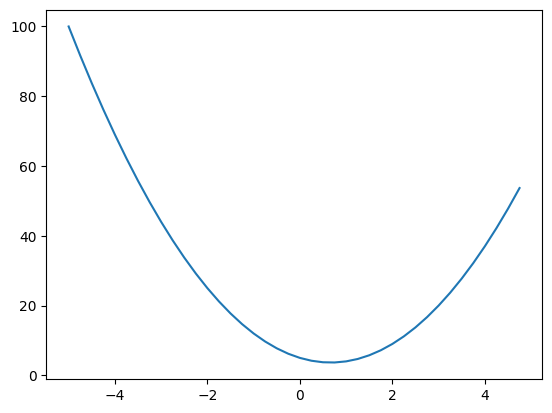

In [4]:
xs = np.arange(-5,5,0.25)
ys =f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.0001
x = 3
(f(x+h)-f(x))/h

14.000300000063248

In [6]:
a= 2
b=-3
c=10
d = (a*b)+c
print(d)

4


In [7]:
h =0.001
a=2
b=-3
c= 10

d1 = a*b+c
a+=h
d2=a*b+c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4
d2 3.997
slope -3.0000000000001137


In [8]:
class Value:
    def __init__(self,data,_children=(),_op='',label=''):
        self.data =data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data, (self,other) ,'+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self,other):
        assert isinstance(other, (int,float)),"only supporting int/float powers for now"
        out = Value(self.data**other,(self,), f'**{other}')

        def _backward():
            self.grad += ((other) * (self.data)**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __radd__(self,other):
        return self+other
        
    def __rmul__(self,other):
        return self *other

    def __truediv__(self,other):
        return self * (other**-1)
        
    def __neg__(self):
        return self * -1
        
    def __sub__(self,other):
        return self + (-other)
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t,(self,),'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [9]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f |grad %.4f}" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [11]:
#inputs x1,x2
x1 = Value(2,label='x1')
x2=Value(0,label='x2')

#weights w1,w2
w1 = Value(-3,label='w1')
w2=Value(1,label='w2')

#bias of the neuron
b = Value(6.8813735870195432,label='b')
# x1w1 + x2w2 +b 
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1+ x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'
o.backward()

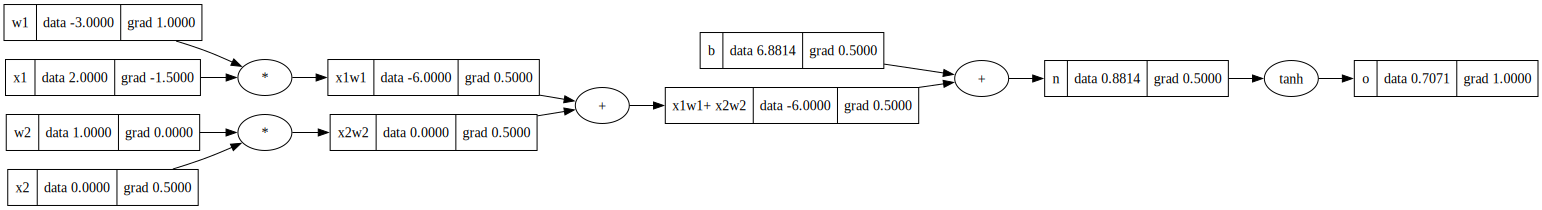

In [12]:
draw_dot(o)

In [13]:
#inputs x1,x2
x1 = Value(2.0,label='x1')
x2=  Value(0.0,label='x2')

#weights w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

#bias of the neuron
b = Value(6.8813735870195432,label='b')
# x1w1 + x2w2 +b 
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1+ x2w2'
n = x1w1x2w2 + b
n.label = 'n'
# ----
e = (n*2).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()

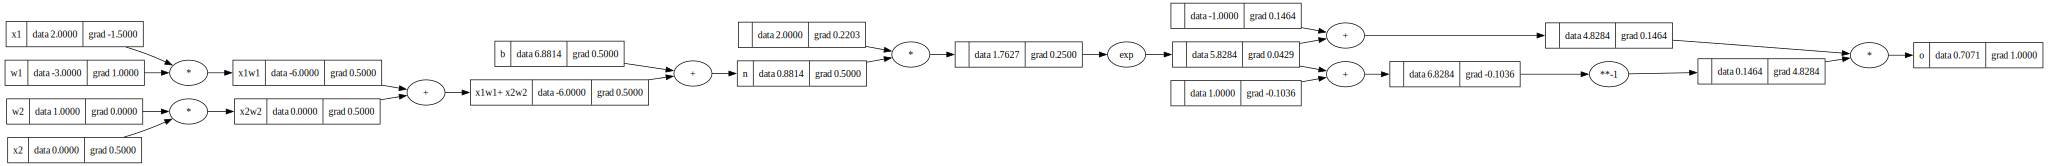

In [14]:
draw_dot(o)

In [15]:
import torch

In [16]:
x1  = torch.Tensor([2.0]).double()                              ; x1.requires_grad = True
x2 = torch.Tensor([0]).double()                                 ; x2.requires_grad = True
w1= torch.Tensor([-3.0]).double()                               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()                 ; b.requires_grad = True
n = x1*w1+x2*w2+b
e = torch.exp(n * 2)
o = (e - 1) / (e + 1)

print(o.data.item())
o.backward()

print('----')
print('x1',x1.grad.item())
print('x2',x2.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())

0.7071066904050358
----
x1 -1.50000038515331
x2 0.5000001283844366
w1 1.0000002567688733
w2 0.0


In [17]:
import random
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b  = Value(random.uniform(-1,1))
    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


# x = [2.0,3.0,-1.0]
# n = MLP(3,[4,4,1])
# n(x)

In [45]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.9208654529038669)

In [44]:
n.parameters()

[Value(data=-0.08360902074548955),
 Value(data=-0.9442130635098408),
 Value(data=-0.298495044535035),
 Value(data=0.10082425815293246),
 Value(data=0.5222968064783076),
 Value(data=0.4728852953106031),
 Value(data=-1.1102621507824615),
 Value(data=0.006441502114569411),
 Value(data=0.0889025794475532),
 Value(data=-0.7787102866514541),
 Value(data=1.8396770881953888),
 Value(data=-0.6697398367308881),
 Value(data=-0.028271296521348105),
 Value(data=1.5861925267588006),
 Value(data=0.017048759991998563),
 Value(data=-0.16323888179705826),
 Value(data=0.7472899930856812),
 Value(data=0.37410485790259235),
 Value(data=1.2039330123026928),
 Value(data=-0.5520064615064773),
 Value(data=-0.17975744352271822),
 Value(data=0.5676325599861504),
 Value(data=0.1485465514248886),
 Value(data=0.15932564648190267),
 Value(data=-0.15524900386012874),
 Value(data=-0.48311129042200573),
 Value(data=0.8452453911803124),
 Value(data=0.5404290959881115),
 Value(data=1.2127604914446786),
 Value(data=-0.760

In [46]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys = [1,-1,-1,1]
# ypred = [n(x) for x in xs]
# ypred

In [20]:
loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys,ypred)))
loss

Value(data=3.279545768949552)

In [63]:
for k in range(20):
    

    #forward pass:
    ypred = [n(x) for x in xs]
    loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys,ypred)))
    
    #backward pass:
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update:
    for p in n.parameters():
        p.data += -0.05*p.grad
    print(k, loss.data)

0 0.0044361402066099296
1 0.004404330448317185
2 0.004372951719621819
3 0.004341995494774487
4 0.004311453468858391
5 0.004281317550737896
6 0.004251579856273936
7 0.004222232701795224
8 0.004193268597813461
9 0.0041646802429724065
10 0.004136460518220543
11 0.004108602481198069
12 0.004081099360828833
13 0.004053944552108617
14 0.004027131611081701
15 0.004000654249997761
16 0.003974506332641389
17 0.003948681869827561
18 0.003923175015056063
19 0.0038979800603179578


In [64]:
ypred

[Value(data=0.9665011376512771),
 Value(data=-0.9775234040583737),
 Value(data=-0.9588664007449983),
 Value(data=0.9759451474985802)]

In [40]:
loss.backward()

In [22]:
n.layers[0].neurons[0].w[0].grad

0.15019549526874915

In [ ]:
draw_dot(loss)

In [25]:
n.layers[0].neurons[0].w[0].data

0.02254225993247938

In [41]:
for p in n.parameters():
    p.data += -0.1*p.grad

In [27]:
n.layers[0].neurons[0].w[0].data

0.007522710405604465

In [42]:
ypred = [n(x) for x in xs]
loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys,ypred)))
loss

Value(data=0.01000501129309271)

In [43]:
ypred

[Value(data=0.9732240731027955),
 Value(data=-0.9990050109334314),
 Value(data=-0.9081972967834792),
 Value(data=0.9706855886843165)]